# Notebook tạo nhiều cấu hình training và trực quan hóa kết quả

Notebook này chạy các cấu hình huấn luyện khác nhau cho mô hình parity/MNIST, lưu log và trực quan hóa loss/accuracy.

## 1. Tải cấu hình cơ bản và thiết lập môi trường

In [1]:
from __future__ import annotations

import json
from dataclasses import dataclass
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt

from arxiv_2601_07223.classifier import ParityClassifier, build_noise_model
from arxiv_2601_07223.data import parity_dataset, mnist_binary_dataset
from arxiv_2601_07223.training import VariationalTrainer

# Thiết lập thư mục log
RESULTS_DIR = Path("results/notebook_runs")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Seed cho reproducibility (trong trainer)
SEED = 123

## 2. Định nghĩa các cấu hình training khác nhau

In [2]:
@dataclass
class TrainConfig:
    name: str
    dataset: str  # "parity" hoặc "mnist"
    mode: str  # "bare", "encoded", "encoded_logical"
    shots: int
    steps: int
    lr: float
    batch_size: int | None
    syndrome_rounds: int
    gate_noise: float
    two_qubit_noise_scale: float
    ancilla_noise: float | None
    # MNIST params
    mnist_digit_positive: int = 0
    mnist_digit_negative: int = 1
    mnist_limit: int = 64
    mnist_threshold: float | None = None
    mnist_data_dir: str = "data"


CONFIGS: List[TrainConfig] = [
    TrainConfig(
        name="parity_encoded_low_noise",
        dataset="parity",
        mode="encoded",
        shots=1024,
        steps=40,
        lr=0.2,
        batch_size=None,
        syndrome_rounds=2,
        gate_noise=0.003,
        two_qubit_noise_scale=2.0,
        ancilla_noise=None,
    ),
    TrainConfig(
        name="parity_bare_no_noise",
        dataset="parity",
        mode="bare",
        shots=1024,
        steps=40,
        lr=0.2,
        batch_size=None,
        syndrome_rounds=0,
        gate_noise=0.0,
        two_qubit_noise_scale=2.0,
        ancilla_noise=None,
    ),
    TrainConfig(
        name="mnist_encoded_fast",
        dataset="mnist",
        mode="encoded",
        shots=2048,
        steps=30,
        lr=0.15,
        batch_size=32,
        syndrome_rounds=2,
        gate_noise=0.003,
        two_qubit_noise_scale=2.0,
        ancilla_noise=None,
        mnist_digit_positive=0,
        mnist_digit_negative=1,
        mnist_limit=64,
    ),
]

## 3. Chạy training theo từng cấu hình

In [3]:
@dataclass
class TrainLog:
    config: TrainConfig
    entries: List[dict]


def load_dataset(cfg: TrainConfig) -> List[Tuple[Tuple[int, int], int]]:
    if cfg.dataset == "parity":
        return parity_dataset()
    return mnist_binary_dataset(
        digit_positive=cfg.mnist_digit_positive,
        digit_negative=cfg.mnist_digit_negative,
        limit_per_class=cfg.mnist_limit,
        data_dir=cfg.mnist_data_dir,
        threshold=cfg.mnist_threshold,
        train_split=True,
    )


def run_training(cfg: TrainConfig) -> TrainLog:
    noise_model = build_noise_model(
        cfg.gate_noise,
        cfg.two_qubit_noise_scale,
        ancilla_error=cfg.ancilla_noise,
    )
    dataset = load_dataset(cfg)
    classifier = ParityClassifier(
        mode=cfg.mode,
        shots=cfg.shots,
        syndrome_rounds=cfg.syndrome_rounds,
        noise_model=noise_model,
    )
    trainer = VariationalTrainer(
        classifier=classifier,
        dataset=dataset,
        learning_rate=cfg.lr,
        batch_size=cfg.batch_size,
        seed=SEED,
    )

    entries: List[dict] = []

    def _log_callback(step: int, theta: float, loss: float, grad: float, acc: float, batch_size: int):
        entries.append(
            {
                "step": step,
                "theta": theta,
                "loss": loss,
                "gradient": grad,
                "accuracy": acc,
                "batch_size": batch_size,
            }
        )

    trainer.train(theta=0.3, steps=cfg.steps, callback=_log_callback)
    return TrainLog(config=cfg, entries=entries)


logs: List[TrainLog] = []
for cfg in CONFIGS:
    print(f"Running: {cfg.name}")
    logs.append(run_training(cfg))

Running: parity_encoded_low_noise
[step 000] theta=0.3587 loss=0.6264 grad=-0.2934 acc=50.00% batch=4
[step 001] theta=0.3966 loss=0.6267 grad=-0.1896 acc=25.00% batch=4
[step 002] theta=0.4345 loss=0.6097 grad=-0.1894 acc=50.00% batch=4
[step 003] theta=0.4800 loss=0.5675 grad=-0.2276 acc=50.00% batch=4
[step 004] theta=0.5181 loss=0.5012 grad=-0.1903 acc=50.00% batch=4
[step 005] theta=0.5482 loss=0.4994 grad=-0.1507 acc=75.00% batch=4
[step 006] theta=0.5646 loss=0.4955 grad=-0.0819 acc=50.00% batch=4
[step 007] theta=0.5741 loss=0.4914 grad=-0.0474 acc=50.00% batch=4
[step 008] theta=0.5828 loss=0.5196 grad=-0.0436 acc=50.00% batch=4
[step 009] theta=0.5852 loss=0.4936 grad=-0.0121 acc=50.00% batch=4
[step 010] theta=0.5880 loss=0.4796 grad=-0.0138 acc=50.00% batch=4
[step 011] theta=0.5902 loss=0.5255 grad=-0.0110 acc=50.00% batch=4
[step 012] theta=0.5921 loss=0.5256 grad=-0.0094 acc=50.00% batch=4
[step 013] theta=0.5941 loss=0.5024 grad=-0.0101 acc=50.00% batch=4
[step 014] the

100.0%
100.0%
100.0%
100.0%


[step 000] theta=0.3156 loss=0.5154 grad=-0.1042 acc=53.12% batch=32
[step 001] theta=0.3499 loss=0.5989 grad=-0.2287 acc=28.12% batch=32
[step 002] theta=0.3922 loss=0.4609 grad=-0.2815 acc=65.62% batch=32
[step 003] theta=0.4365 loss=0.4653 grad=-0.2957 acc=56.25% batch=32
[step 004] theta=0.4794 loss=0.5226 grad=-0.2860 acc=46.88% batch=32
[step 005] theta=0.5020 loss=0.5203 grad=-0.1508 acc=46.88% batch=32
[step 006] theta=0.5262 loss=0.5043 grad=-0.1612 acc=53.12% batch=32
[step 007] theta=0.5444 loss=0.5103 grad=-0.1211 acc=40.62% batch=32
[step 008] theta=0.5553 loss=0.5251 grad=-0.0726 acc=40.62% batch=32
[step 009] theta=0.5629 loss=0.5237 grad=-0.0509 acc=43.75% batch=32
[step 010] theta=0.5661 loss=0.5237 grad=-0.0213 acc=43.75% batch=32
[step 011] theta=0.5678 loss=0.5104 grad=-0.0113 acc=50.00% batch=32
[step 012] theta=0.5713 loss=0.5300 grad=-0.0234 acc=46.88% batch=32
[step 013] theta=0.5724 loss=0.5511 grad=-0.0069 acc=37.50% batch=32
[step 014] theta=0.5734 loss=0.481

## 4. Ghi log và lưu metrics

In [4]:
for log in logs:
    payload = {
        "args": {
            "dataset": log.config.dataset,
            "mode": log.config.mode,
            "gate_noise": log.config.gate_noise,
            "shots": log.config.shots,
            "steps": log.config.steps,
            "lr": log.config.lr,
            "batch_size": log.config.batch_size,
            "syndrome_rounds": log.config.syndrome_rounds,
        },
        "dataset_size": len(load_dataset(log.config)),
        "entries": log.entries,
    }
    out_path = RESULTS_DIR / f"{log.config.name}.json"
    out_path.write_text(json.dumps(payload, indent=2))
    print(f"Saved: {out_path}")

Saved: results/notebook_runs/parity_encoded_low_noise.json
Saved: results/notebook_runs/parity_bare_no_noise.json
Saved: results/notebook_runs/mnist_encoded_fast.json


## 5. Visualization: loss/accuracy theo epoch

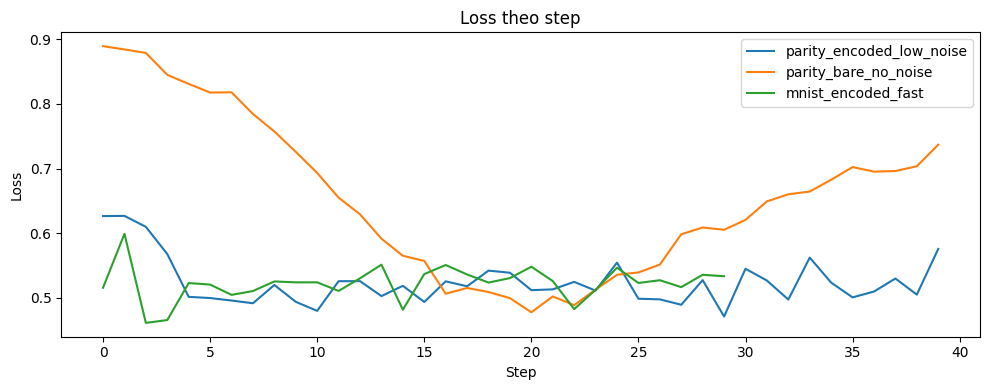

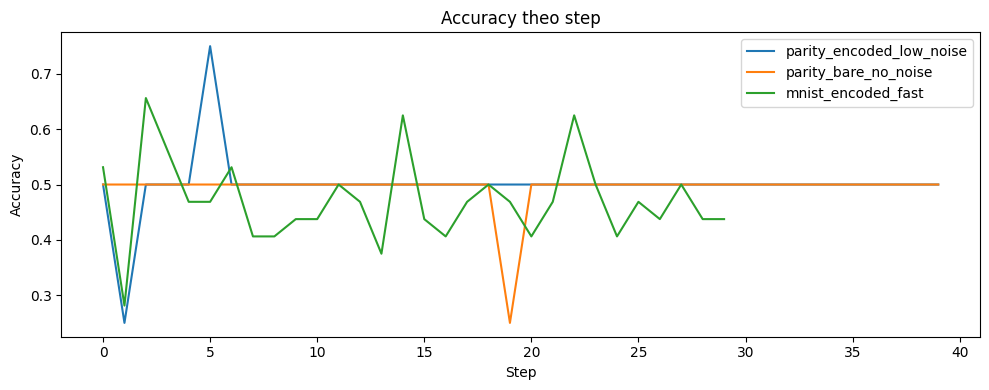

In [5]:
plt.figure(figsize=(10, 4))
for log in logs:
    steps = [e["step"] for e in log.entries]
    losses = [e["loss"] for e in log.entries]
    plt.plot(steps, losses, label=log.config.name)
plt.title("Loss theo step")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
for log in logs:
    steps = [e["step"] for e in log.entries]
    accs = [e["accuracy"] for e in log.entries]
    plt.plot(steps, accs, label=log.config.name)
plt.title("Accuracy theo step")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()

## 6. Visualization: so sánh cấu hình

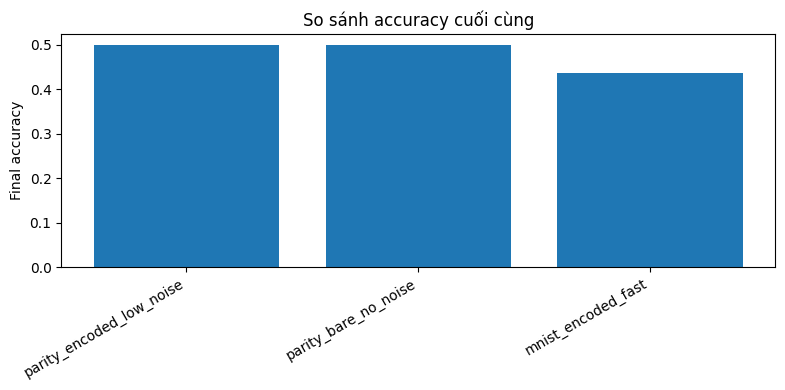

In [6]:
final_accs = [(log.config.name, log.entries[-1]["accuracy"]) for log in logs]
final_accs.sort(key=lambda x: x[1], reverse=True)

names = [x[0] for x in final_accs]
values = [x[1] for x in final_accs]

plt.figure(figsize=(8, 4))
plt.bar(names, values)
plt.title("So sánh accuracy cuối cùng")
plt.ylabel("Final accuracy")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()